In [ ]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


tqdm.pandas()


sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (14, 7)

print("Libraries imported successfully.")


Libraries imported successfully.


In [ ]:
METADATA_PATH = Path(r"path/to/your/directory/metadata.csv")

if not METADATA_PATH.exists():
    print(f"ERROR: Metadata file not found at '{METADATA_PATH}'")
else:
    df = pd.read_csv(METADATA_PATH)
    print("Metadata.csv loaded successfully.")
    print(f"Total records found: {len(df)}")
    display(df.head())


Metadata.csv loaded successfully.
Total records found: 27222


image_path  \
0  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
1  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
2  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
3  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
4  C:\Users\HP\Desktop\droneaimodel\final_dataset...   

                                           mask_path      class  split  
0  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train  
1  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train  
2  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train  
3  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train  
4  C:\Users\HP\Desktop\droneaimodel\final_dataset...  non_crack  train

In [ ]:


def analyze_crack_geometry(mask_path_str):
    """
    Analyzes a single mask image to find the properties of all cracks within it.
    
    Args:
        mask_path_str (str): The file path to the mask image.

    Returns:
        list: A list of dictionaries, where each dictionary contains the
              properties (length, width, angle) of one detected crack contour.
              Returns an empty list if no cracks are found or the file is invalid.
    """
    mask_path = Path(mask_path_str)
    if not mask_path.exists():
        return []

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return []


    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    properties = []
    for contour in contours:
       
        if cv2.contourArea(contour) < 10:
            continue

        
        rect = cv2.minAreaRect(contour)
        
        
        (w, h) = rect[1]
        width = min(w, h)
        length = max(w, h)
        
        
        angle = rect[2]
        
       
        if w < h: 
            orientation = angle + 90
        else: 
            orientation = angle

        properties.append({
            'length_pixels': length,
            'width_pixels': width,
            'orientation_degrees': orientation
        })
        
    return properties


In [ ]:


print("Applying geometric analysis to all crack masks. This may take several minutes...")


crack_df = df[df['class'] == 'crack'].copy()
print(f"Found {len(crack_df)} 'crack' samples to analyze.")


crack_df['geometry_data'] = crack_df['mask_path'].progress_apply(analyze_crack_geometry)

print("\nAnalysis complete. Geometric properties have been extracted.")
display(crack_df.head())


Applying geometric analysis to all crack masks. This may take several minutes...
Found 13611 'crack' samples to analyze.


  0%|          | 0/13611 [00:00<?, ?it/s]


Analysis complete. Geometric properties have been extracted.


image_path  \
10946  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
10947  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
10948  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
10949  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
10950  C:\Users\HP\Desktop\droneaimodel\final_dataset...   

                                               mask_path  class  split  \
10946  C:\Users\HP\Desktop\droneaimodel\final_dataset...  crack  train   
10947  C:\Users\HP\Desktop\droneaimodel\final_dataset...  crack  train   
10948  C:\Users\HP\Desktop\droneaimodel\final_dataset...  crack  train   
10949  C:\Users\HP\Desktop\droneaimodel\final_dataset...  crack  train   
10950  C:\Users\HP\Desktop\droneaimodel\final_dataset...  crack  train   

                                           geometry_data  
10946  [{'length_pixels': 531.2614135742188, 'width_p...  
10947  [{'length_pixels': 568.6820068359375, 'width_p...  
10948  [{'length_pixels': 511.5887451171875, 'width_p...  
10949  [{'length_pixels': 469.1004333496094, 'width_p...  
10950  [{'length_pixels': 511.04315185546875, 'width_...

In [ ]:

crack_df_filtered = crack_df[crack_df['geometry_data'].apply(lambda x: len(x) > 0)].copy()


crack_geometries = crack_df_filtered.explode('geometry_data')


geometries_df = pd.json_normalize(crack_geometries['geometry_data'])
final_geometries_df = pd.concat([
    crack_geometries[['image_path', 'mask_path']].reset_index(drop=True),
    geometries_df
], axis=1)

print(f"Created a new DataFrame with {len(final_geometries_df)} individual crack measurements.")
display(final_geometries_df.head())


Created a new DataFrame with 35285 individual crack measurements.


image_path  \
0  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
1  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
2  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
3  C:\Users\HP\Desktop\droneaimodel\final_dataset...   
4  C:\Users\HP\Desktop\droneaimodel\final_dataset...   

                                           mask_path  length_pixels  \
0  C:\Users\HP\Desktop\droneaimodel\final_dataset...     531.261414   
1  C:\Users\HP\Desktop\droneaimodel\final_dataset...     568.682007   
2  C:\Users\HP\Desktop\droneaimodel\final_dataset...     511.588745   
3  C:\Users\HP\Desktop\droneaimodel\final_dataset...     469.100433   
4  C:\Users\HP\Desktop\droneaimodel\final_dataset...     511.043152   

   width_pixels  orientation_degrees  
0    416.354187            85.436180  
1    363.238251           167.156120  
2    363.699951            91.949742  
3    400.656555            90.926536  
4     68.142090            82.234833

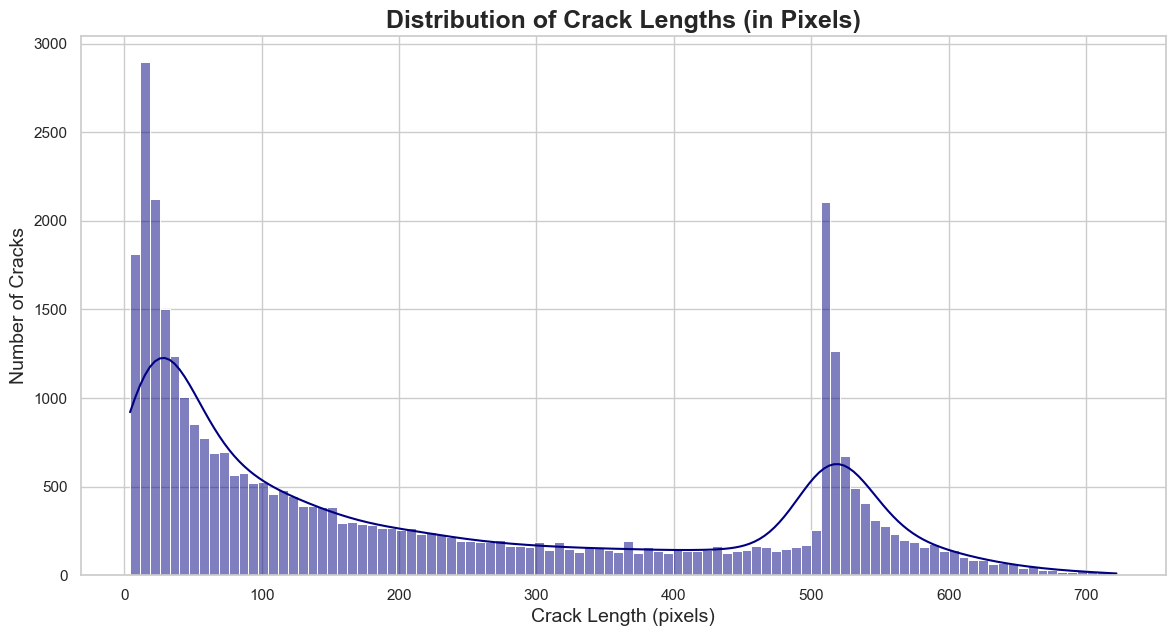

This plot helps you understand if your dataset is biased towards long or short cracks.


In [ ]:


plt.figure(figsize=(14, 7))
sns.histplot(final_geometries_df['length_pixels'], bins=100, kde=True, color='navy')
plt.title('Distribution of Crack Lengths (in Pixels)', fontsize=18, weight='bold')
plt.xlabel('Crack Length (pixels)', fontsize=14)
plt.ylabel('Number of Cracks', fontsize=14)
plt.show()

print("This plot helps you understand if your dataset is biased towards long or short cracks.")


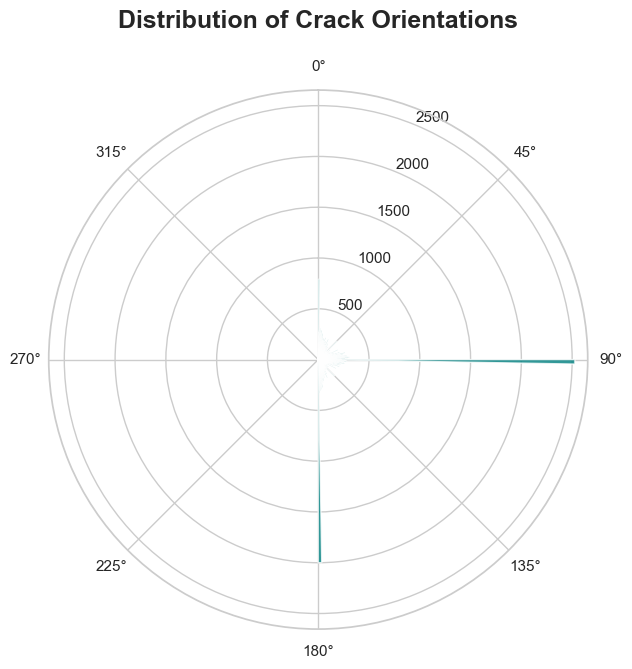

This plot shows the prevalence of crack angles. 0° is vertical, 90° is horizontal.
A uniform distribution is ideal, while strong peaks indicate a potential bias in the dataset.


In [ ]:

plt.figure(figsize=(14, 7))

orientations = final_geometries_df['orientation_degrees']

orientations_rad = np.deg2rad(orientations)

ax = plt.subplot(111, polar=True)
ax.hist(orientations_rad, bins=180, color='teal', alpha=0.8) 
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_title('Distribution of Crack Orientations', fontsize=18, weight='bold', y=1.1)
plt.show()

print("This plot shows the prevalence of crack angles. 0° is vertical, 90° is horizontal.")
print("A uniform distribution is ideal, while strong peaks indicate a potential bias in the dataset.")


In [ ]:


OUTPUT_GEOMETRY_CSV = Path("./crack_geometries.csv")
final_geometries_df.to_csv(OUTPUT_GEOMETRY_CSV, index=False)

print(f"Successfully saved the detailed crack geometry data to: '{OUTPUT_GEOMETRY_CSV}'")


Successfully saved the detailed crack geometry data to: 'crack_geometries.csv'


--- Visualizing Geometric Analysis Results ---


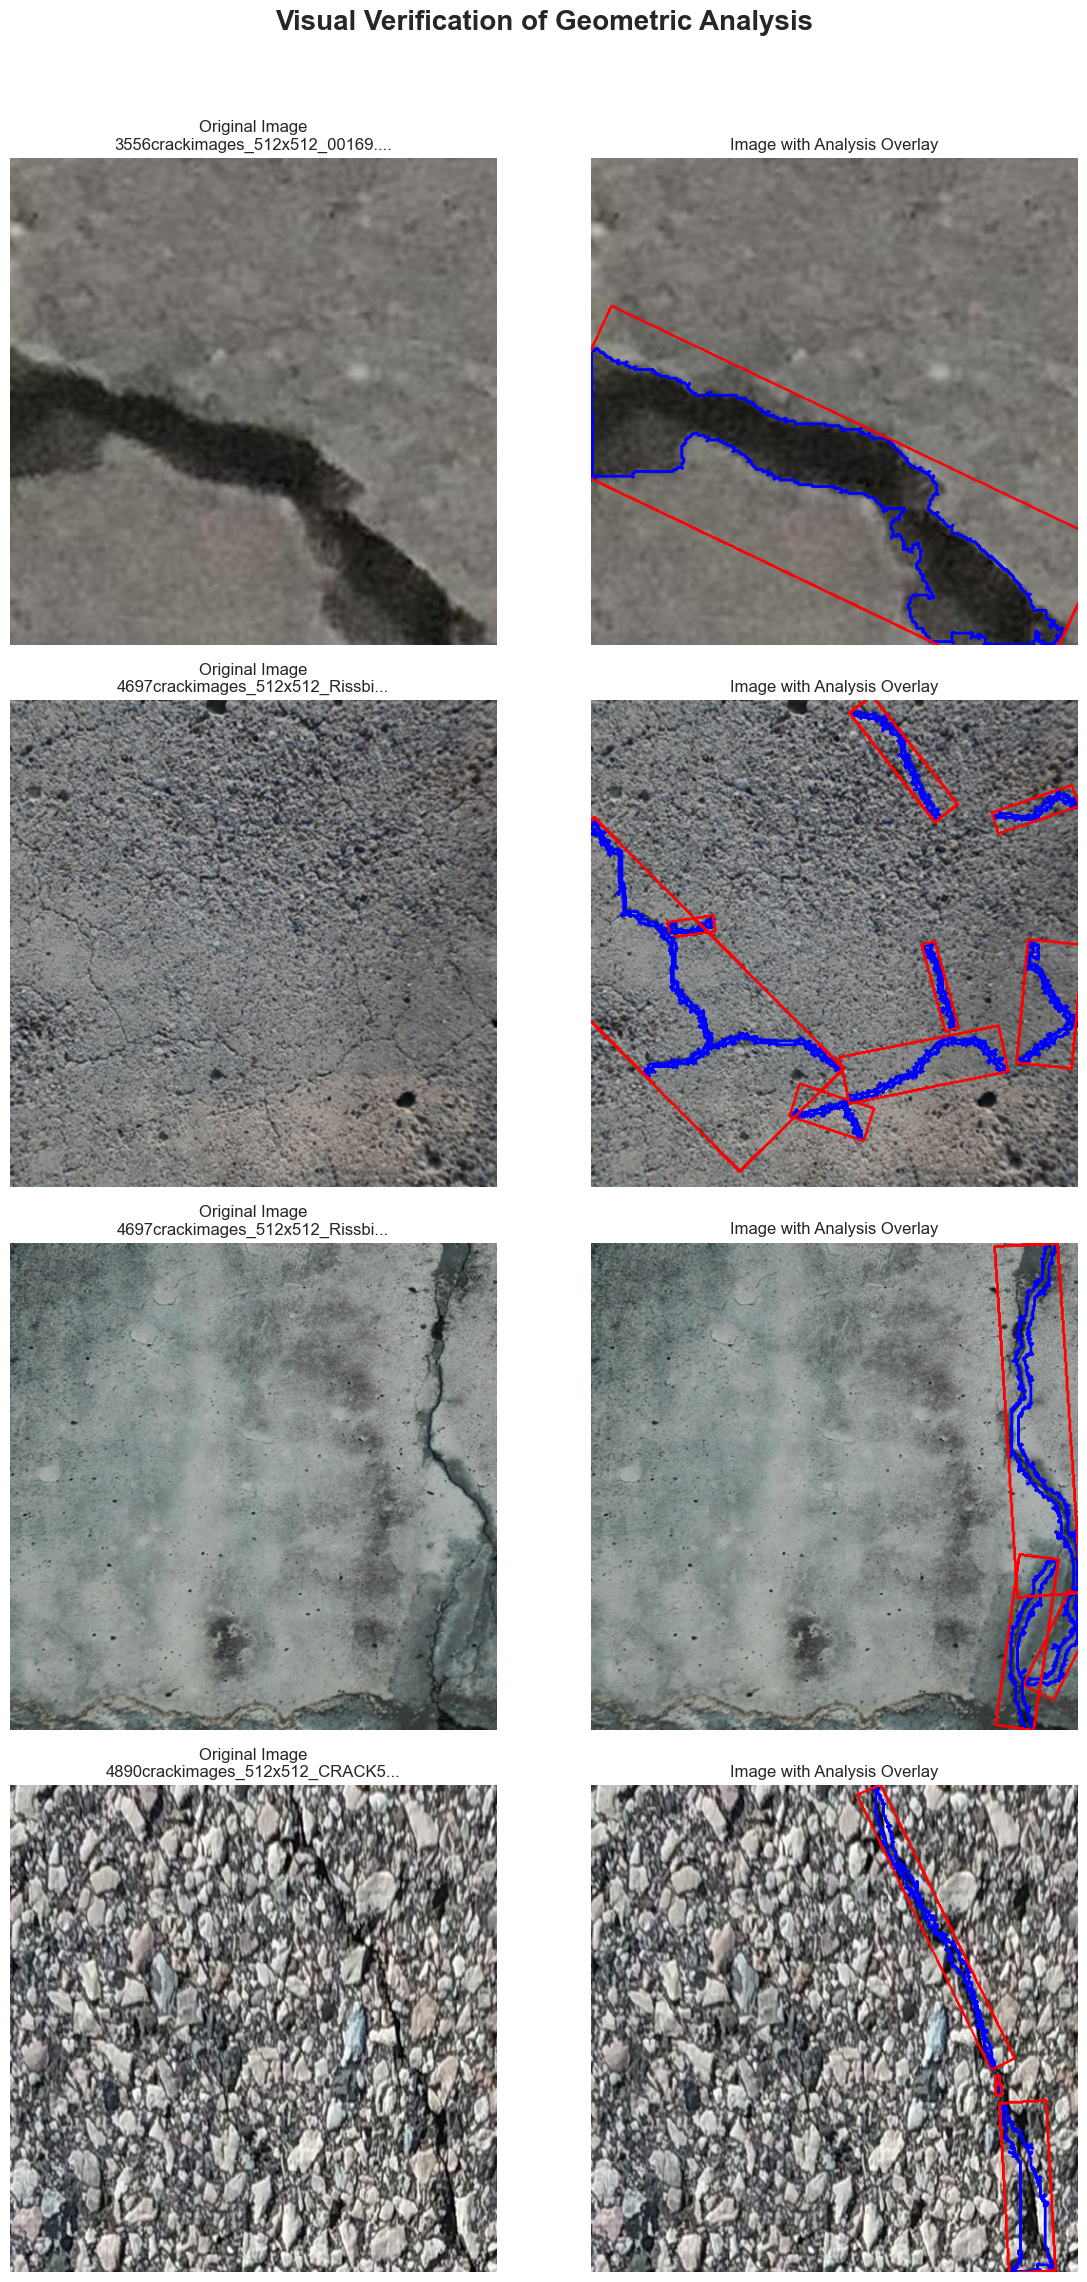


Blue Outline = The actual crack contour found from the mask.
Red Rotated Box = The bounding box used to calculate length, width, and orientation.


In [ ]:
print("--- Visualizing Geometric Analysis Results ---")
NUM_VISUAL_SAMPLES = 4


sample_geometries = final_geometries_df.sample(NUM_VISUAL_SAMPLES)

fig, axes = plt.subplots(NUM_VISUAL_SAMPLES, 2, figsize=(12, NUM_VISUAL_SAMPLES * 6))
fig.suptitle("Visual Verification of Geometric Analysis", fontsize=20, weight='bold', y=0.95)

for i, (index, row) in enumerate(sample_geometries.iterrows()):
   
    image_path = row['image_path']
    mask_path = row['mask_path']
    
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    overlay_image = original_image.copy()
    
    for contour in contours:
        if cv2.contourArea(contour) < 10:
            continue
            
        
        rect = cv2.minAreaRect(contour)
       
        box = cv2.boxPoints(rect)
      
        box = np.int_(box) 
        
        
        cv2.drawContours(overlay_image, [contour], -1, (255, 0, 0), 2) 
        
        cv2.drawContours(overlay_image, [box], 0, (0, 0, 255), 2) 

    overlay_image_rgb = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)

    
    axes[i, 0].imshow(original_image_rgb)
    axes[i, 0].set_title(f"Original Image\n{Path(image_path).name[:30]}...")
    axes[i, 0].axis('off')
    
    
    axes[i, 1].imshow(overlay_image_rgb)
    axes[i, 1].set_title("Image with Analysis Overlay")
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

print("\nBlue Outline = The actual crack contour found from the mask.")
print("Red Rotated Box = The bounding box used to calculate length, width, and orientation.")


--- Visualizing Geometric Analysis Results ---


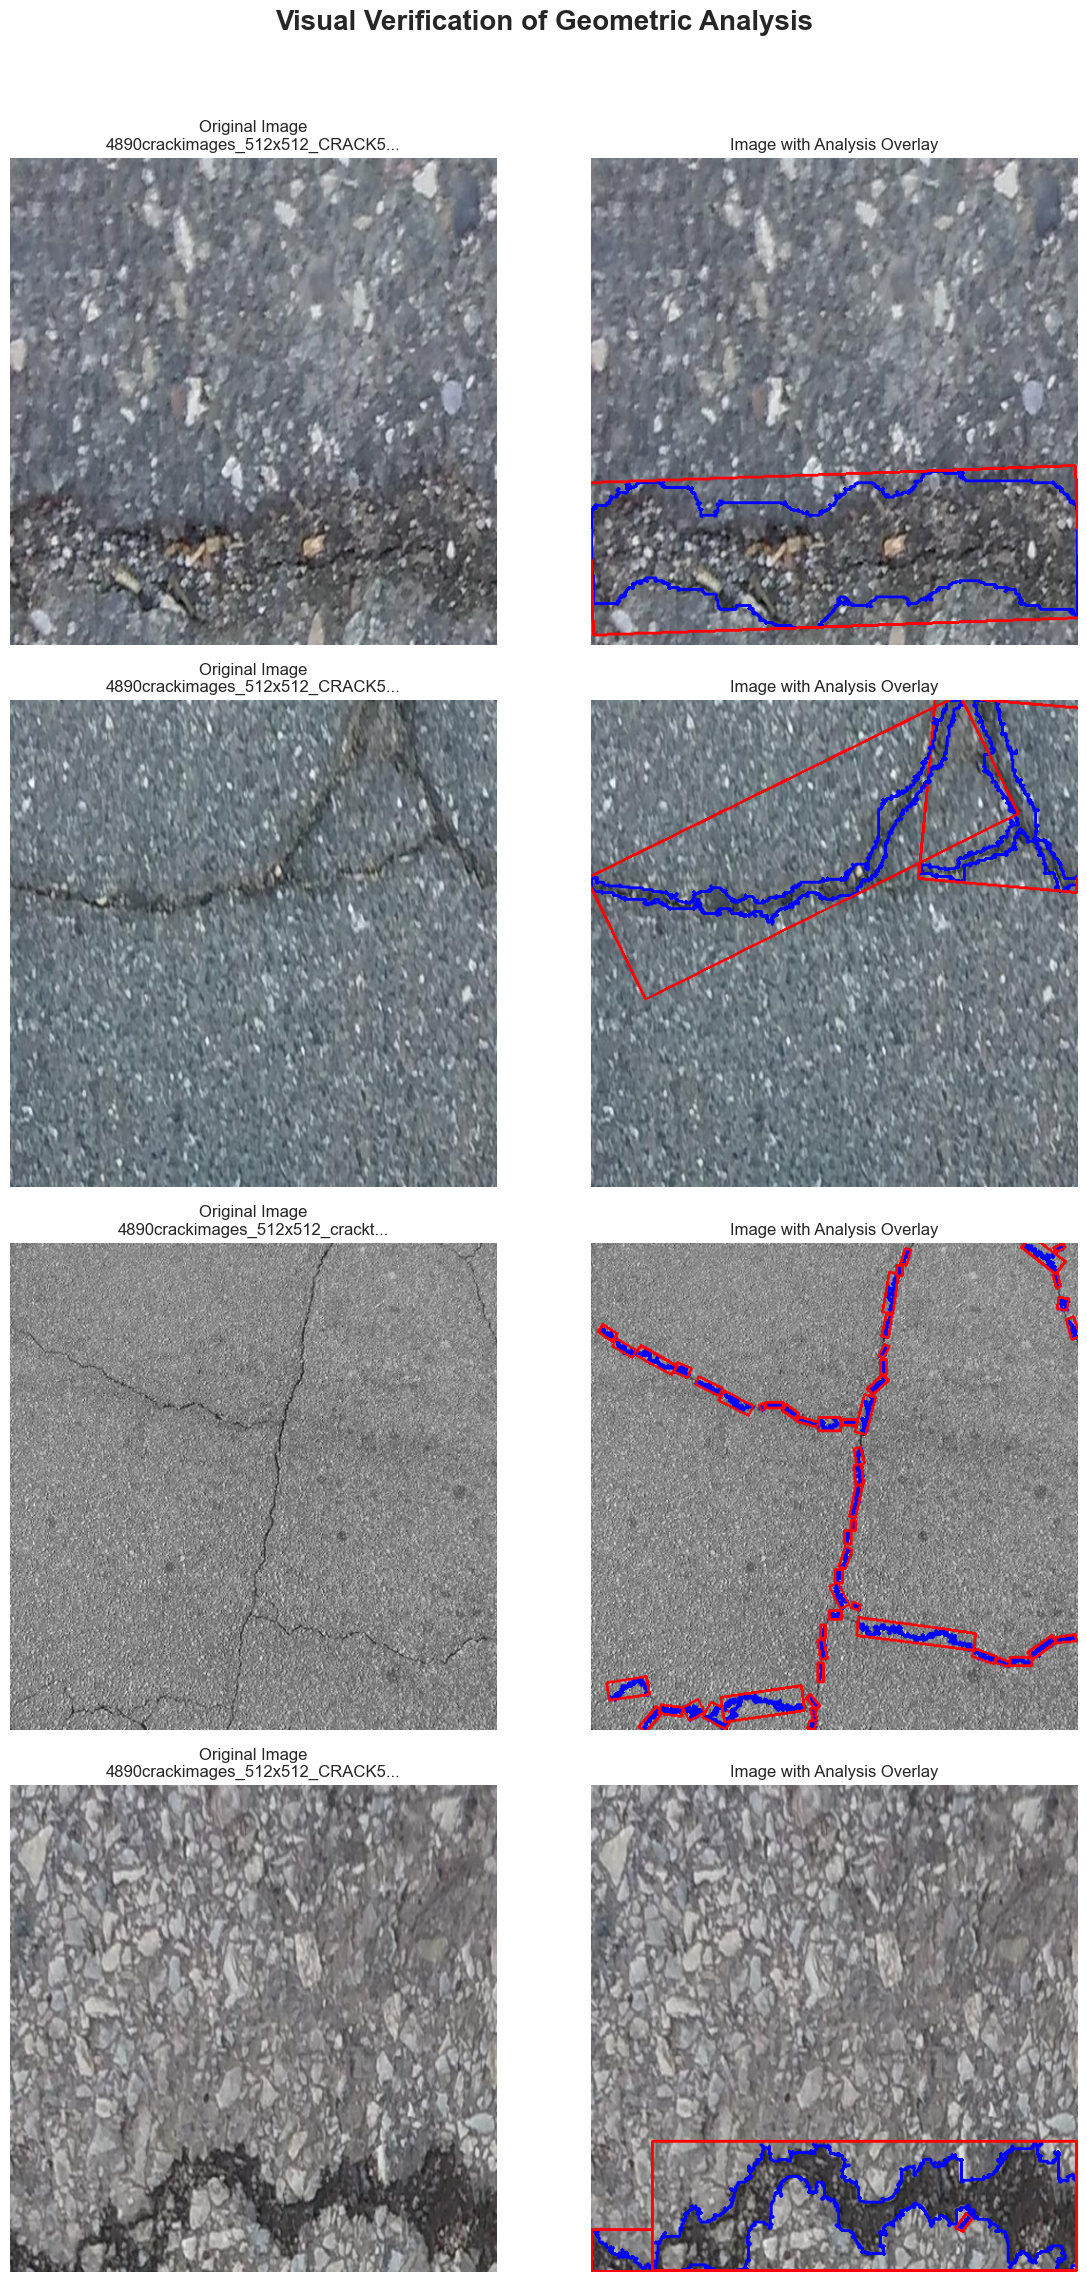


Blue Outline = The actual crack contour found from the mask.
Red Rotated Box = The bounding box used to calculate length, width, and orientation.


In [ ]:
print("--- Visualizing Geometric Analysis Results ---")
NUM_VISUAL_SAMPLES = 4


sample_geometries = final_geometries_df.sample(NUM_VISUAL_SAMPLES)

fig, axes = plt.subplots(NUM_VISUAL_SAMPLES, 2, figsize=(12, NUM_VISUAL_SAMPLES * 6))
fig.suptitle("Visual Verification of Geometric Analysis", fontsize=20, weight='bold', y=0.95)

for i, (index, row) in enumerate(sample_geometries.iterrows()):
    
    image_path = row['image_path']
    mask_path = row['mask_path']
    
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
   
    overlay_image = original_image.copy()
    
    for contour in contours:
        if cv2.contourArea(contour) < 10:
            continue
            
        
        rect = cv2.minAreaRect(contour)
      
        box = cv2.boxPoints(rect)
        box = np.int_(box) 
        
      
        cv2.drawContours(overlay_image, [contour], -1, (255, 0, 0), 2) 
     
        cv2.drawContours(overlay_image, [box], 0, (0, 0, 255), 2) 

    overlay_image_rgb = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)

   
    axes[i, 0].imshow(original_image_rgb)
    axes[i, 0].set_title(f"Original Image\n{Path(image_path).name[:30]}...")
    axes[i, 0].axis('off')
    
    
    axes[i, 1].imshow(overlay_image_rgb)
    axes[i, 1].set_title("Image with Analysis Overlay")
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

print("\nBlue Outline = The actual crack contour found from the mask.")
print("Red Rotated Box = The bounding box used to calculate length, width, and orientation.")
